In [1]:
'''
This code cell distributes all files into three lists: train, val, unlabelled 
'''
import os
val_list = open('val.txt', 'w+')
unlabeled_list = open('unlabeled.txt','w+')
train_list = open('train.txt', 'w+')

val_subject_id = ['13','35','36']#['11','12','16','21','23']
source = '/data/LAIPAS_Images/img/'
msk_dir = '/data/LAIPAS_Images/msks/'
for filename in os.listdir(source):
    if filename in os.listdir(msk_dir):
        if filename[8:10] in val_subject_id:
            print(filename,file=val_list)
        else:
            print(filename,file=train_list)
    else:
        print(filename,file=unlabeled_list)
        
val_list.close()
unlabeled_list.close()
train_list.close()


In [2]:
'''
preparing metadata of the dataset for 
stratified sampling (balance on patients)
'''
import numpy as np
for setname in ['val.txt','train.txt','unlabeled.txt']:
    temp_dict = {}
    f = open(setname,'r')
    for filename in f.read().split():
        patient_id = [s for s in filename.split('_') if s.isdigit()][0]
        
        if patient_id not in temp_dict.keys():
            temp_dict[patient_id] = [filename]
        else:
            temp_dict[patient_id].append(filename)
            
    f.close()
    np.save(setname[:-4]+'_stratify',temp_dict)


In [1]:
'''This code augments original msks with uncertainty label'''
import os, cv2 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
source_dir = '/data/LAIPAS_Images/msks/'
# target_dir = '/data/LAIPAS_Images/msks_aug/'
target_dir = '/data/LAIPAS_Images/msks_aug2/'
width = 5

for filename in os.listdir(source_dir):
    msk = np.array(Image.open(source_dir+filename))
    h,w = msk.shape
    msk_padded=np.pad(msk,width,'symmetric')
    msk_out = np.zeros((h+2*width,w+2*width), dtype = 'uint8')
    temp = []
    for i in range(-1,2):
        for j in range(-1,2):
            temp.append(msk_padded[width+i:-width+i,width+j:-width+j]==msk)
    temp =  ~np.logical_and.reduce(np.array(temp),axis=0)
    edges_idx = np.argwhere(temp)
    
    edges_idx +=width
    for anchor in edges_idx:
        
        #Using L_infinity distance for uncertainty range
#         msk_out[anchor[0]-width//2:anchor[0]+width//2+1,
#                 anchor[1]-width//2:anchor[1]+width//2+1] = 255
        
        #Use L_1 distance for uncertainty range
        for i in range(-width//2, width//2+1):
            for j in range(-width//2, width//2+1):
                if abs(i)+abs(j)<= width//2:
                    msk_out[anchor[0]+i,anchor[1]+j]=255
    
    
    output = np.where(msk_out[width:-width,width:-width]==255,255,msk)
    
    assert output.shape == msk.shape
    
    cv2.imwrite(target_dir+filename,np.array(output,dtype='uint8'))
#     plt.imshow(temp)
#     plt.show()
#     plt.imshow(msk)
#     plt.show()
#     plt.imshow(output)
    
    

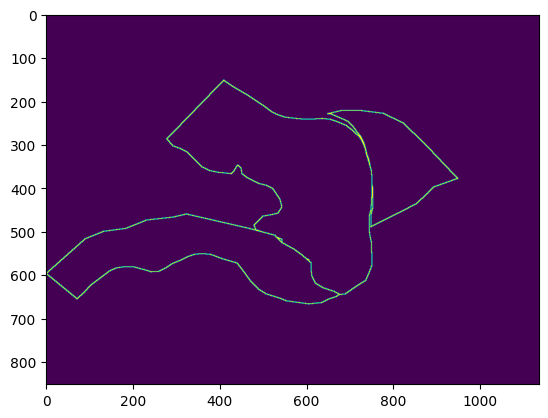

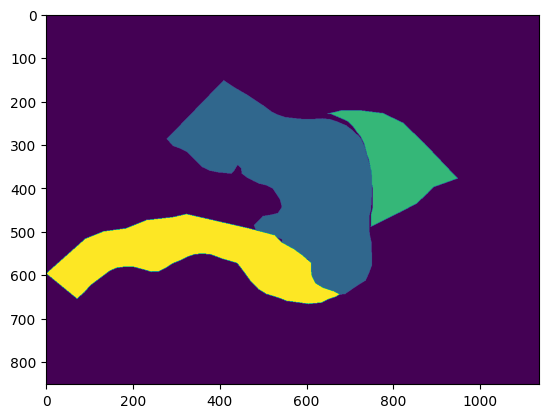

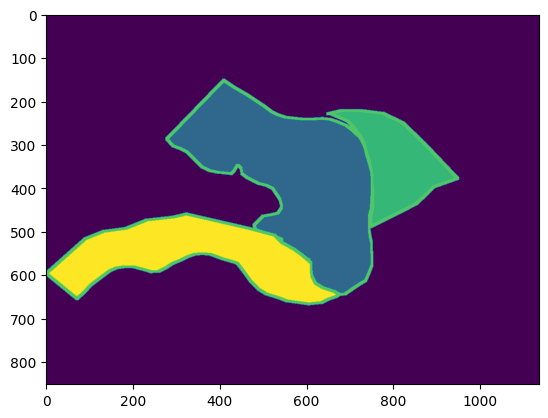

In [8]:
plt.imshow(temp)
plt.show()
plt.imshow(msk)
plt.show()
plt.imshow(output*80)

In [1]:
'''This code augments original msks with uncertainty label'''
import os, cv2 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
source_dir = '/data/LAIPAS_Images/msks/'
entropy_dir = '/data/LAIPAS_Images/entropy_msk/'
window_size = 224

assert window_size%8 == 0

for filename in os.listdir(source_dir):
    msk = np.array(Image.open(source_dir+filename))
    msk_padded=np.pad(msk,window_size//2,'symmetric')
    h0,w0 = msk.shape
    h, w = msk_padded.shape
    msk_padded = cv2.resize(msk_padded, (w//4,h//4),interpolation=cv2.INTER_NEAREST)
    out = np.zeros_like(msk_padded).astype('float')
    
    small_window = window_size//4
    
    for i in range(window_size//8, h//4-window_size//8+1):
        for j in range(window_size//8, w//4-window_size//8+1):
            block = msk_padded[i-window_size//8:i+window_size//8+1,
                               j-window_size//8:j+window_size//8+1]
            val, cnt = np.unique(block,return_counts=True)
            cnt = np.array(cnt,dtype='float') / cnt.sum()
            out[i,j] = -np.sum(cnt*np.log(cnt))+5e-2
    out = cv2.resize(out[window_size//8:h//4-window_size//8+1,
                         window_size//8:w//4-window_size//8+1],(w0,h0))
    
    out_ = (out/out.max()*255).astype('uint8')
    cv2.imwrite(entropy_dir+filename,out_)


    

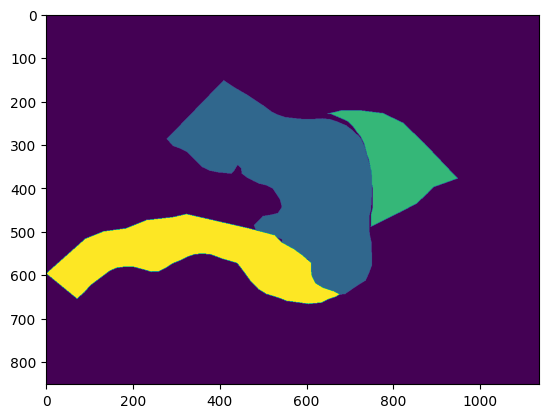

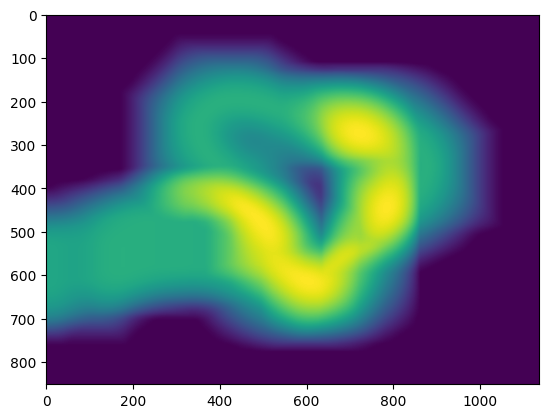

In [21]:
plt.imshow(msk)
plt.show()
plt.imshow(out)

In [9]:
out.mean()

0.3803298481666184